# User Churn Prediction

In this project, I use supervised learning model(Logistic Regression) to identify customers who are likely to stop using service in the future.

## Contents

<ul>
<li>[Part 1: Data Exploration](#Part-1:-Data-Exploration) 
<li>[Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
<li>[Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
<li>[Part 4: Tuning the Parameters of the model](#Part-3:-Tuning the Parameters of the model)

### Note - If **'Churn.xlsx'** is not present in the content directory then please upload it.The file is present in the shared drive folder.

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
import copy
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy
from PIL import Image
from scipy import ndimage
df=pd.read_excel('Churn.xlsx')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [ ]:
# make general plots to examine each feature
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by churned or not
    if continuous:
        sns.boxplot(x=col_name, y='churned', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = df.groupby(col_name)['ch'].value_counts(normalize=True)[:,1]
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction churned')
        ax2.set_title('churned Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'churned', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='churned', data=df, order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
missing_values_table(df)

Your selected dataframe has 21 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values,type
TotalCharges,11,0.2,float64


In [ ]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1914,5356-CSVSQ,Female,0,No,No,3,Yes,Yes,DSL,No,No,No,Yes,Yes,No,Month-to-month,No,Electronic check,64.60,174.20,No
6397,7994-XIRTR,Male,1,No,No,54,Yes,No,DSL,No,No,Yes,Yes,No,Yes,One year,No,Bank transfer (automatic),65.25,3529.95,No
1576,0993-OSGPT,Female,1,Yes,No,68,Yes,No,DSL,No,Yes,Yes,Yes,No,No,One year,Yes,Bank transfer (automatic),60.65,3975.90,No
2476,9135-MGVPY,Male,0,Yes,No,69,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Mailed check,84.70,5878.90,No
6810,7758-XKCBS,Male,0,No,No,15,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.70,438.25,Yes


**bold text**### Part 1.2:  Understand the features & the target
The target variable is "Churned". I will perform EDA on the features, the target varible and their correlations.

#### Target variable:

In [ ]:
df.Churn.value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

About 73% of the customers stayed and 17% churned. Unbalanced data. I will try to handle this unbalance in the cross validation and need to pick appropriate metrics.

#### Features:

In [ ]:
df.sample(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6716,9850-OWRHQ,Female,0,Yes,No,3,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),74.1,228.0,Yes


In [ ]:
df.groupby('Churn').mean()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
Churn,,,,
No,0.128721,37.569965,61.265124,2555.344141
Yes,0.254682,17.979133,74.441332,1531.796094


#### Linear Correlation 

In [ ]:
df.churned = df.Churn.map({'False.':0, 'True.':1})

In [ ]:
corr = df.drop(['gender'], axis=1).corr()
#corr

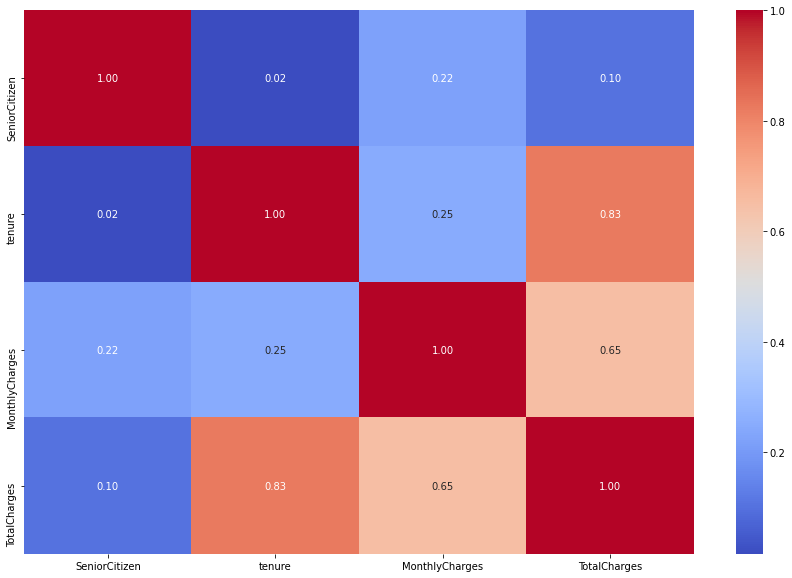

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
cm_df = sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

# Part 2: Feature Preprocessing And Cleaning

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Drop some useless columns
drop_list = ['customerID','gender','Partner','Dependents','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

In [ ]:
d = {"No": 0, "Yes": 1}
X = df.drop(drop_list, axis=1)
d2 = {False: 0, True : 1}
X["InternetService"]=X["InternetService"]=="No"
X["InternetService"] = X["InternetService"].map(d2)
X["PhoneService"] = X["PhoneService"].map(d)
X["Churn"] = X["Churn"].map(d)
k=X[["MonthlyCharges"]].min()
l=X[["MonthlyCharges"]].max()
m=X[["MonthlyCharges"]].mean()
X["MonthlyCharges"]=(X["MonthlyCharges"]-m[0])/(l[0]-k[0])
k=X[["TotalCharges"]].min()
l=X[["TotalCharges"]].max()
m=X[["TotalCharges"]].mean()
X["TotalCharges"]=(X["TotalCharges"]-m[0])/(l[0]-k[0])
k=X[["tenure"]].min()
l=X[["tenure"]].max()
m=X[["tenure"]].mean()
X["tenure"]=(X["tenure"]-m[0])/(l[0]-k[0])
k=X[["InternetService"]].min()
l=X[["InternetService"]].max()
m=X[["InternetService"]].mean()
X["InternetService"]=(X["InternetService"]-m[0])/(l[0]-k[0])
k=X[["PhoneService"]].min()
l=X[["PhoneService"]].max()
m=X[["PhoneService"]].mean()
X["PhoneService"]=(X["PhoneService"]-m[0])/(l[0]-k[0])
k=X[["SeniorCitizen"]].min()
l=X[["SeniorCitizen"]].max()
m=X[["SeniorCitizen"]].mean()
X["SeniorCitizen"]=(X["SeniorCitizen"]-m[0])/(l[0]-k[0])
X.sample(5)
print()
print("printing the count of infinity values")
print()
count = np.isnan(X).values.sum()
print("It contains " + str(count) + " infinite values")
X.dropna(subset = ["MonthlyCharges","TotalCharges","tenure","InternetService","PhoneService","SeniorCitizen"], inplace=True)
print()
print("printing the count of infinity values")
print()
count = np.isnan(X).values.sum()
print("It contains " + str(count) + " infinite values")
y=X["Churn"]
X=X.drop(["Churn"],axis=1)


printing the count of infinity values

It contains 11 infinite values

printing the count of infinity values

It contains 0 infinite values


In [ ]:
X.sample(5)

,SeniorCitizen,tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges
6644,-0.162147,0.397623,0.096834,-0.216669,0.315804,0.391230
4880,-0.162147,0.244845,0.096834,0.783331,-0.439917,-0.140278
4681,0.837853,-0.324599,0.096834,-0.216669,0.189933,-0.172300
5660,-0.162147,0.161512,0.096834,-0.216669,0.127247,0.137064
2058,-0.162147,0.550401,0.096834,-0.216669,0.217794,0.454823


In [ ]:

# Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#splitting data using sklearn library


In [ ]:
#creating datsets
X_train.to_csv( 'X_train.csv', header=None,index=None, sep=',', mode='a')
X_test.to_csv( 'X_test.csv', header=None,index=None, sep=',', mode='a')
y_train.to_csv( 'Y_train.csv', header=None,index=None, sep=',', mode='a')
y_test.to_csv( 'Y_test.csv', header=None,index=None, sep=',', mode='a')


In [ ]:
X.sample(5)

,SeniorCitizen,tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges
571,0.837853,0.203178,0.096834,-0.216669,-0.051360,0.054316
2107,-0.162147,0.008734,0.096834,-0.216669,0.284461,0.093319
1953,-0.162147,-0.435710,0.096834,-0.216669,0.105356,-0.254783
1397,-0.162147,-0.394044,0.096834,-0.216669,0.179983,-0.226598
2579,-0.162147,0.217067,0.096834,0.783331,-0.443897,-0.150052


## Part 3 Making and Traning The Model

In [ ]:

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s=1/(1+np.exp(-z))
    
    return s

In [ ]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w=np.zeros((dim,1))
    b=0.0000    
    return w, b

In [ ]:

def propagate(w, b, X, Y,lmbda):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m =float (X.shape[1])
    A=sigmoid(np.dot(w.T,X)+b)
    cost=(-1/m)*(float(np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))))
    reg=(lmbda/2)*(np.dot(w.T,w))
    reg=reg/m
    dw=((1/m)*(np.dot(X,(A-Y).T)))
    db=(1/m)*np.sum((A-Y))
    cost = np.squeeze(np.array(cost))
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [ ]:

def optimize(w, b, X, Y,lmbda, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        #print('\nIlteration number ',i,' ..................... ')
        grads,cost=propagate(w, b, X, Y,lmbda)
        dw = grads["dw"]
        db = grads["db"]
        w=w-learning_rate*dw
        b=b-learning_rate*db
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
  
    params = {"w": w,
              "b": b}
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    A=sigmoid(np.dot(w.T,X)+b)
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
             Y_prediction[0,i] = 1
        else:
             Y_prediction[0,i] = 0
    return Y_prediction

In [ ]:
#Loading the Dataset
df1 = pd.read_csv('X_test.csv')
X_test = df1.to_numpy()
X_test=X_test.T
print('Shape X_test = ',X_test.shape)
df2 = pd.read_csv('X_train.csv')
X_train = df2.to_numpy()
X_train=X_train.T
print('Shape X_train = ',X_train.shape)
df3 = pd.read_csv('Y_test.csv')
Y_test = df3.to_numpy()
Y_test=Y_test.T
print('Shape Y_test = ',Y_test.shape)
df4 = pd.read_csv('Y_train.csv')
Y_train = df4.to_numpy()
Y_train=Y_train.T
print('Shape Y_train = ',Y_train.shape)
print('Checking for inf values ')
np.any(np.isnan(X_train))
np.any(np.isnan(X_test))


Shape X_test =  (6, 1406)
Shape X_train =  (6, 5624)
Shape Y_test =  (1, 1406)
Shape Y_train =  (1, 5624)
Checking for inf values 


False

In [ ]:
def model(X_train, Y_train, X_test, Y_test,lmbda, num_iterations=2000, learning_rate=0.086, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w, b, X_train, Y_train,lmbda, num_iterations, learning_rate,print_cost)
    w = params["w"]
    b = params["b"]
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    #print('\n Learned Parameteres ....\n')
    #print(w)
    print('\n Plotting the Learning Curve\n')
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    

In [ ]:
logistic_regression_model = model(X_train, Y_train, X_test, Y_test,100,num_iterations=2000, learning_rate=0.086, print_cost=True)

## Part 4 Tuning the parameteres

In [ ]:
learning_rates = [0.5, 0.7,0.04,0.07,0.09,0.087,0.01,0.009,0.009,0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(X_train, Y_train, X_test, Y_test,100, num_iterations=2000, learning_rate=lr, print_cost=True)
    print ('\n' + "-------------------------------------------------------" + '\n')

# **Conclusion**

>**Model Trained** - Logistic Regression 


> **Learning** Rate =0.087

> **Accuracy**

1.   test accuracy: 78.59 %
2.   train accuracy: 79.12 %


 






